### 3 Analysis - Tissue Separation

A sliding window approach was applied on the whole slide images (WSIs) with the trained CNN model to generate confidence heatmaps. 

The WSIs were tiled into 1536 x 1536 images patches in the prepocessing steps. A sliding window approached was applied on evey image patch of a WSI. At each time, the CNN model took a 256x256 pixels region as input, forward propagated and generated a prediction score for cored plaque, diffuse plaque and CAA respectively. By systematically sliding the input region across the entire 1536 x 1536 image patch, the prediction scores were saved and ploted as prediction confidence heatmap for this patch. The heatmap for the WSI was obtained by doing this on all image patches of it.

Based on the heatmap prediction scores (saved as npy), we analyzed the plaque density distribution

In [1]:
import os, glob, datetime
from time import time
from tqdm import tqdm

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [2]:
IMG_DIR  = 'data/outputs/norm_png/'
SAVE_DIR = 'data/outputs/heatmaps/'

filenames = glob.glob(IMG_DIR + '*.png')
filenames = [filename.split('/')[-1] for filename in filenames]
print(filenames)

['NA3777-02_AB.png', 'NA3777-02_AB_Eosin.png', 'NA3777-02_AB_Eosin_4.png', 'NA3777-02_AB_Eosin_sliced.png', 'NA3777-02_AB_Hemato.png', 'NA3777-02_AB_Hemato_4.png', 'NA3777-02_AB_Hemato_sliced.png', 'NA3777-02_AB_HSVMSK.png', 'NA4077-02_AB.png', 'NA4092-02_AB.png', 'NA4107-02_AB.png', 'NA4160-02_AB.png', 'NA4195-02_AB.png', 'NA4256-02_AB.png', 'NA4299-02_AB.png', 'NA4391-02_AB.png', 'NA4450-02_AB.png', 'NA4463-02_AB.png', 'NA4471-02_AB.png', 'NA4553-02_AB.png', 'NA4626-02_AB.png', 'NA4672-02_AB.png', 'NA4675-02_AB.png', 'NA4691-02_AB.png', 'NA4695-02_AB.png']


### Latest Scikit-image Canny Algorithm

In [3]:
"""
canny.py - Canny Edge detector

Reference: Canny, J., A Computational Approach To Edge Detection, IEEE Trans.
    Pattern Analysis and Machine Intelligence, 8:679-714, 1986

Originally part of CellProfiler, code licensed under both GPL and BSD licenses.
Website: http://www.cellprofiler.org
Copyright (c) 2003-2009 Massachusetts Institute of Technology
Copyright (c) 2009-2011 Broad Institute
All rights reserved.
Original author: Lee Kamentsky
"""

import numpy as np
import scipy.ndimage as ndi
from scipy.ndimage import generate_binary_structure
from skimage.filters import gaussian
from skimage import dtype_limits, img_as_float
from skimage._shared.utils import assert_nD


def smooth_with_function_and_mask(image, function, mask):
    """Smooth an image with a linear function, ignoring masked pixels

    Parameters
    ----------
    image : array
        Image you want to smooth.
    function : callable
        A function that does image smoothing.
    mask : array
        Mask with 1's for significant pixels, 0's for masked pixels.

    Notes
    ------
    This function calculates the fractional contribution of masked pixels
    by applying the function to the mask (which gets you the fraction of
    the pixel data that's due to significant points). We then mask the image
    and apply the function. The resulting values will be lower by the
    bleed-over fraction, so you can recalibrate by dividing by the function
    on the mask to recover the effect of smoothing from just the significant
    pixels.
    """
    bleed_over = function(mask.astype(float))
    masked_image = np.zeros(image.shape, image.dtype)
    masked_image[mask] = image[mask]
    smoothed_image = function(masked_image)
    output_image = smoothed_image / (bleed_over + np.finfo(float).eps)
    return output_image


def canny(image, sigma=1., low_threshold=None, high_threshold=None, mask=None,
          use_quantiles=False):
    """Edge filter an image using the Canny algorithm.

    Parameters
    -----------
    image : 2D array
        Grayscale input image to detect edges on; can be of any dtype.
    sigma : float
        Standard deviation of the Gaussian filter.
    low_threshold : float
        Lower bound for hysteresis thresholding (linking edges).
        If None, low_threshold is set to 10% of dtype's max.
    high_threshold : float
        Upper bound for hysteresis thresholding (linking edges).
        If None, high_threshold is set to 20% of dtype's max.
    mask : array, dtype=bool, optional
        Mask to limit the application of Canny to a certain area.
    use_quantiles : bool, optional
        If True then treat low_threshold and high_threshold as quantiles of the
        edge magnitude image, rather than absolute edge magnitude values. If True
        then the thresholds must be in the range [0, 1].

    Returns
    -------
    output : 2D array (image)
        The binary edge map.

    See also
    --------
    skimage.sobel

    Notes
    -----
    The steps of the algorithm are as follows:

    * Smooth the image using a Gaussian with ``sigma`` width.

    * Apply the horizontal and vertical Sobel operators to get the gradients
      within the image. The edge strength is the norm of the gradient.

    * Thin potential edges to 1-pixel wide curves. First, find the normal
      to the edge at each point. This is done by looking at the
      signs and the relative magnitude of the X-Sobel and Y-Sobel
      to sort the points into 4 categories: horizontal, vertical,
      diagonal and antidiagonal. Then look in the normal and reverse
      directions to see if the values in either of those directions are
      greater than the point in question. Use interpolation to get a mix of
      points instead of picking the one that's the closest to the normal.

    * Perform a hysteresis thresholding: first label all points above the
      high threshold as edges. Then recursively label any point above the
      low threshold that is 8-connected to a labeled point as an edge.

    References
    -----------
    .. [1] Canny, J., A Computational Approach To Edge Detection, IEEE Trans.
           Pattern Analysis and Machine Intelligence, 8:679-714, 1986
    .. [2] William Green's Canny tutorial
           http://dasl.unlv.edu/daslDrexel/alumni/bGreen/www.pages.drexel.edu/_weg22/can_tut.html

    Examples
    --------
    >>> from skimage import feature
    >>> # Generate noisy image of a square
    >>> im = np.zeros((256, 256))
    >>> im[64:-64, 64:-64] = 1
    >>> im += 0.2 * np.random.rand(*im.shape)
    >>> # First trial with the Canny filter, with the default smoothing
    >>> edges1 = feature.canny(im)
    >>> # Increase the smoothing for better results
    >>> edges2 = feature.canny(im, sigma=3)
    """

    #
    # The steps involved:
    #
    # * Smooth using the Gaussian with sigma above.
    #
    # * Apply the horizontal and vertical Sobel operators to get the gradients
    #   within the image. The edge strength is the sum of the magnitudes
    #   of the gradients in each direction.
    #
    # * Find the normal to the edge at each point using the arctangent of the
    #   ratio of the Y sobel over the X sobel - pragmatically, we can
    #   look at the signs of X and Y and the relative magnitude of X vs Y
    #   to sort the points into 4 categories: horizontal, vertical,
    #   diagonal and antidiagonal.
    #
    # * Look in the normal and reverse directions to see if the values
    #   in either of those directions are greater than the point in question.
    #   Use interpolation to get a mix of points instead of picking the one
    #   that's the closest to the normal.
    #
    # * Label all points above the high threshold as edges.
    # * Recursively label any point above the low threshold that is 8-connected
    #   to a labeled point as an edge.
    #
    # Regarding masks, any point touching a masked point will have a gradient
    # that is "infected" by the masked point, so it's enough to erode the
    # mask by one and then mask the output. We also mask out the border points
    # because who knows what lies beyond the edge of the image?
    #
    assert_nD(image, 2)
    dtype_max = dtype_limits(image, clip_negative=False)[1]

    if low_threshold is None:
        low_threshold = 0.1
    else:
        low_threshold = low_threshold / dtype_max

    if high_threshold is None:
        high_threshold = 0.2
    else:
        high_threshold = high_threshold / dtype_max

    if mask is None:
        mask = np.ones(image.shape, dtype=bool)

    def fsmooth(x):
        return img_as_float(gaussian(x, sigma, mode='constant'))

    smoothed = smooth_with_function_and_mask(image, fsmooth, mask)
    jsobel = ndi.sobel(smoothed, axis=1)
    isobel = ndi.sobel(smoothed, axis=0)
    abs_isobel = np.abs(isobel)
    abs_jsobel = np.abs(jsobel)
    magnitude = np.hypot(isobel, jsobel)

    #
    # Make the eroded mask. Setting the border value to zero will wipe
    # out the image edges for us.
    #
    s = generate_binary_structure(2, 2)
    eroded_mask = ndi.binary_erosion(mask, s, border_value=0)
    eroded_mask = eroded_mask & (magnitude > 0)
    #
    #--------- Find local maxima --------------
    #
    # Assign each point to have a normal of 0-45 degrees, 45-90 degrees,
    # 90-135 degrees and 135-180 degrees.
    #
    local_maxima = np.zeros(image.shape, bool)
    #----- 0 to 45 degrees ------
    pts_plus = (isobel >= 0) & (jsobel >= 0) & (abs_isobel >= abs_jsobel)
    pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    # Get the magnitudes shifted left to make a matrix of the points to the
    # right of pts. Similarly, shift left and down to get the points to the
    # top right of pts.
    c1 = magnitude[1:, :][pts[:-1, :]]
    c2 = magnitude[1:, 1:][pts[:-1, :-1]]
    m = magnitude[pts]
    w = abs_jsobel[pts] / abs_isobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[:-1, :][pts[1:, :]]
    c2 = magnitude[:-1, :-1][pts[1:, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 45 to 90 degrees ------
    # Mix diagonal and vertical
    #
    pts_plus = (isobel >= 0) & (jsobel >= 0) & (abs_isobel <= abs_jsobel)
    pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel <= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1 = magnitude[:, 1:][pts[:, :-1]]
    c2 = magnitude[1:, 1:][pts[:-1, :-1]]
    m = magnitude[pts]
    w = abs_isobel[pts] / abs_jsobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[:, :-1][pts[:, 1:]]
    c2 = magnitude[:-1, :-1][pts[1:, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 90 to 135 degrees ------
    # Mix anti-diagonal and vertical
    #
    pts_plus = (isobel <= 0) & (jsobel >= 0) & (abs_isobel <= abs_jsobel)
    pts_minus = (isobel >= 0) & (jsobel <= 0) & (abs_isobel <= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1a = magnitude[:, 1:][pts[:, :-1]]
    c2a = magnitude[:-1, 1:][pts[1:, :-1]]
    m = magnitude[pts]
    w = abs_isobel[pts] / abs_jsobel[pts]
    c_plus = c2a * w + c1a * (1.0 - w) <= m
    c1 = magnitude[:, :-1][pts[:, 1:]]
    c2 = magnitude[1:, :-1][pts[:-1, 1:]]
    c_minus = c2 * w + c1 * (1.0 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 135 to 180 degrees ------
    # Mix anti-diagonal and anti-horizontal
    #
    pts_plus = (isobel <= 0) & (jsobel >= 0) & (abs_isobel >= abs_jsobel)
    pts_minus = (isobel >= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1 = magnitude[:-1, :][pts[1:, :]]
    c2 = magnitude[:-1, 1:][pts[1:, :-1]]
    m = magnitude[pts]
    w = abs_jsobel[pts] / abs_isobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[1:, :][pts[:-1, :]]
    c2 = magnitude[1:, :-1][pts[:-1, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus

    #
    #---- If use_quantiles is set then calculate the thresholds to use
    #
    if use_quantiles:
        if high_threshold > 1.0 or low_threshold > 1.0:
            raise ValueError("Quantile thresholds must not be > 1.0")
        if high_threshold < 0.0 or low_threshold < 0.0:
            raise ValueError("Quantile thresholds must not be < 0.0")

        high_threshold = np.percentile(magnitude, 100.0 * high_threshold)
        low_threshold = np.percentile(magnitude, 100.0 * low_threshold)

    #
    #---- Create two masks at the two thresholds.
    #
    high_mask = local_maxima & (magnitude >= high_threshold)
    low_mask = local_maxima & (magnitude >= low_threshold)

    #
    # Segment the low-mask, then only keep low-segments that have
    # some high_mask component in them
    #
    strel = np.ones((3, 3), bool)
    labels, count = ndi.label(low_mask, strel)
    if count == 0:
        return low_mask

    sums = (np.array(ndi.sum(high_mask, labels,
                             np.arange(count, dtype=np.int32) + 1),
                     copy=False, ndmin=1))
    good_label = np.zeros((count + 1,), bool)
    good_label[1:] = sums > 0
    output_mask = good_label[labels]
    return output_mask

### Superpixel

In [4]:
# Superpixel
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float

img = np.array(Image.open('data/outputs/norm_png/NA3777-02_AB_Eosin.png'))
# Binary Thresholding
img = np.where(img < 15, 0, 255).astype('uint8')
height, width = img.shape
print(img.shape)

(47616, 55296)


In [5]:
import cppyy
cppyy.load_library('gSLICr/build/libgSLICr_lib.so')
cppyy.load_library('/usr/local/cuda-10.0/targets/x86_64-linux/lib/libcudart.so')
cppyy.add_include_path('/usr/local/cuda-10.0/targets/x86_64-linux/include')   # Add cuda library
cppyy.include('gSLICr/gSLICr_Lib/gSLICr.h')
from cppyy.gbl import gSLICr
import cppyy.ll
from skimage.segmentation import mark_boundaries

currentDT = datetime.datetime.now(); print(str(currentDT)); startT = time()
# Create a Run_SLIC C++ class
run_slic = gSLICr.Run_SLIC()
print("Run_SLIC: %s" % (time()-startT))

# Specify settings
gslic_settings = run_slic.get_settings()
gslic_settings = cppyy.bind_object(gslic_settings, gSLICr.objects.settings)
gslic_settings.img_size.x = width
gslic_settings.img_size.y = height
gslic_settings.no_segs = 40000
gslic_settings.no_iters = 1
gslic_settings.coh_weight = 0.01
gslic_settings.do_enforce_connectivity = True
gslic_settings.slic_zero = True
gslic_settings.color_space = gSLICr.GRAY
gslic_settings.seg_method = gSLICr.GIVEN_NUM
run_slic.print_settings()

# Start running gSLIC
run_slic.run(img)
print("run: %s" % (time()-startT))

# Get the segmentation mask
segments_slic = run_slic.get_mask()
print("get_mask: %s" % (time()-startT))

segments_slic.reshape((height*width,))
segments_slic = np.frombuffer(segments_slic, dtype=np.intc, count=height*width).reshape((height, width)).copy()
print("reshape: %s" % (time()-startT))

run_slic.__destruct__()
print("__destruct__: %s" % (time()-startT))
# 81 to 73 after block-dim=32 using slic iter=0
# Down to 50 after changing from Float3Image to FloatImage

np.save('segments_slico_iter=1_40000', segments_slic)
print("save as npy: %s" % (time()-startT))

# Scale [0,1] to [0,255]
def uint8scale(arr, _min=0, _max=1):
    return ((arr - _min) * 1/(_max - _min) * 255).astype('uint8')

print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
mark_img = mark_boundaries(img, segments_slic, outline_color=(1,1,0), mode='thick')
print('Marked')
del segments_slic#, img
norm_img = uint8scale(mark_img)
print('Normalized')
del mark_img

save_img = Image.fromarray(norm_img, 'RGB')
save_img.save('NA3777-02_AB_Eosin_SLICO_iter=1.png')
del save_img
print('Saved')

2019-09-25 04:27:48.306533
Run_SLIC: 0.0037255287170410156
run: 56.46482563018799
get_mask: 56.470247745513916
reshape: 59.7572078704834
__destruct__: 60.66013026237488
save as npy: 105.95129084587097
SLIC number of segments: 39775
Marked
Normalized
Saved


In [ ]:
# Superpixel
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float

# Scale [0,1] to [0,255]
def uint8scale(arr, _min=0, _max=1):
    return ((arr - _min) * 1/(_max - _min) * 255).astype('uint8')

img = np.array(Image.open('data/outputs/norm_png/NA3777-02_AB_Eosin.png'))
# Binary Thresholding
img = np.where(img < 15, 0, 255).astype('uint8')
height, width = img.shape
print(img.shape)

img = img_as_float(img)

# Max memory 123+16 using float64. 255 segments. Run time: 1324 seconds = 22 minutes
currentDT = datetime.datetime.now(); print(str(currentDT)); startT = time()
segments_slic = slic(img, n_segments=5000, compactness=0.01, slic_zero=True)
print("SLIC: %s" % (time()-startT))
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))

del img
img = np.array(Image.open('data/outputs/norm_png/NA3777-02_AB_Eosin.png'))
# Binary Thresholding
img = np.where(img < 15, 0, 255).astype('uint8')
print('Loaded')
mark_img = mark_boundaries(img, segments_slic, outline_color=(1,1,0), mode='thick')
print('Marked')
del segments_slic, img
norm_img = uint8scale(mark_img)
print('Normalized')
del mark_img

save_img = Image.fromarray(norm_img, 'RGB')
save_img.save('NA3777-02_AB_Eosin_SLIC.png')

print('Saved')
print("Total: %s" % (time()-startT))

### Mean Intensity Threshold

In [7]:
segments_slic = np.load('segments_slic_40000.npy')
img = np.array(Image.open('data/outputs/norm_png/NA3777-02_AB_Eosin.png'))
# Binary Thresholding
img = np.where(img < 15, 0, 255).astype('uint8')
height, width = img.shape

In [8]:
from skimage.measure import regionprops

mean_intensity_thres = 60
mask_img = np.zeros_like(img, dtype='uint8')
for region in regionprops(segments_slic, img):
    if region.mean_intensity >= mean_intensity_thres:
        mask_img.flat[np.ravel_multi_index(region.coords.transpose(), mask_img.shape)] = 255

### Connected Component

In [9]:
from skimage.measure import label
connected_comp = label(mask_img, connectivity=2)
print('Number of connected components: {}'.format(len(np.unique(connected_comp))))

Number of connected components: 57


In [10]:
for region in regionprops(connected_comp, img):
    print(region.area)

1399042303
46191
95716365
330686
42859
20003298
38873
194670
52884
95276
96505
95416
47322
58235
44730
502348
69597
86402
85969
51959
45637
100604
44846
282714
39039
170853
45856
48476
52952
102997
109706
20558342
795528
138415
47498
40764
176199
97697
38332
37637
95085
144906
153202
44021
78247
120356
47836
79292
90796
157394
624247
78111
480492
53430
157083
273274


In [11]:
mask_img2 = np.zeros_like(img, dtype='uint8')
for region in regionprops(connected_comp, img):
    if region.area >= 1e8:
        mask_img2.flat[np.ravel_multi_index(region.coords.transpose(), mask_img2.shape)] = 255

### Find and Extend Boundaries

In [12]:
from skimage.segmentation import find_boundaries

boundaries = find_boundaries(mask_img2, connectivity=2, mode='thick')

### Associate with SLICO labels

In [13]:
labels = np.unique(segments_slic[boundaries])
print(len(labels))

2172


In [14]:
# Keep only medium intensity labels
lower_thres = 60
upper_thres = 180
edge_labels = []
for region in regionprops(segments_slic, img):
    mean_inten = region.mean_intensity
    if region.label in labels and mean_inten >= 60 and mean_inten <= 180:
        edge_labels.append(region.label)
print(len(edge_labels))

137


In [11]:
# Mark boundaries for visualization
del mask_img, mask_img2, connected_comp, boundaries

from skimage.segmentation import mark_boundaries

mark_img = mark_boundaries(img, segments_slic, mode='thick')
# Scale to uint8
mark_img *= 255
mark_img = mark_img.astype('uint8')

Average HBOS Runtime: 0.012262773513793946 sec
Average IForest Runtime: 1.9581107378005982 sec


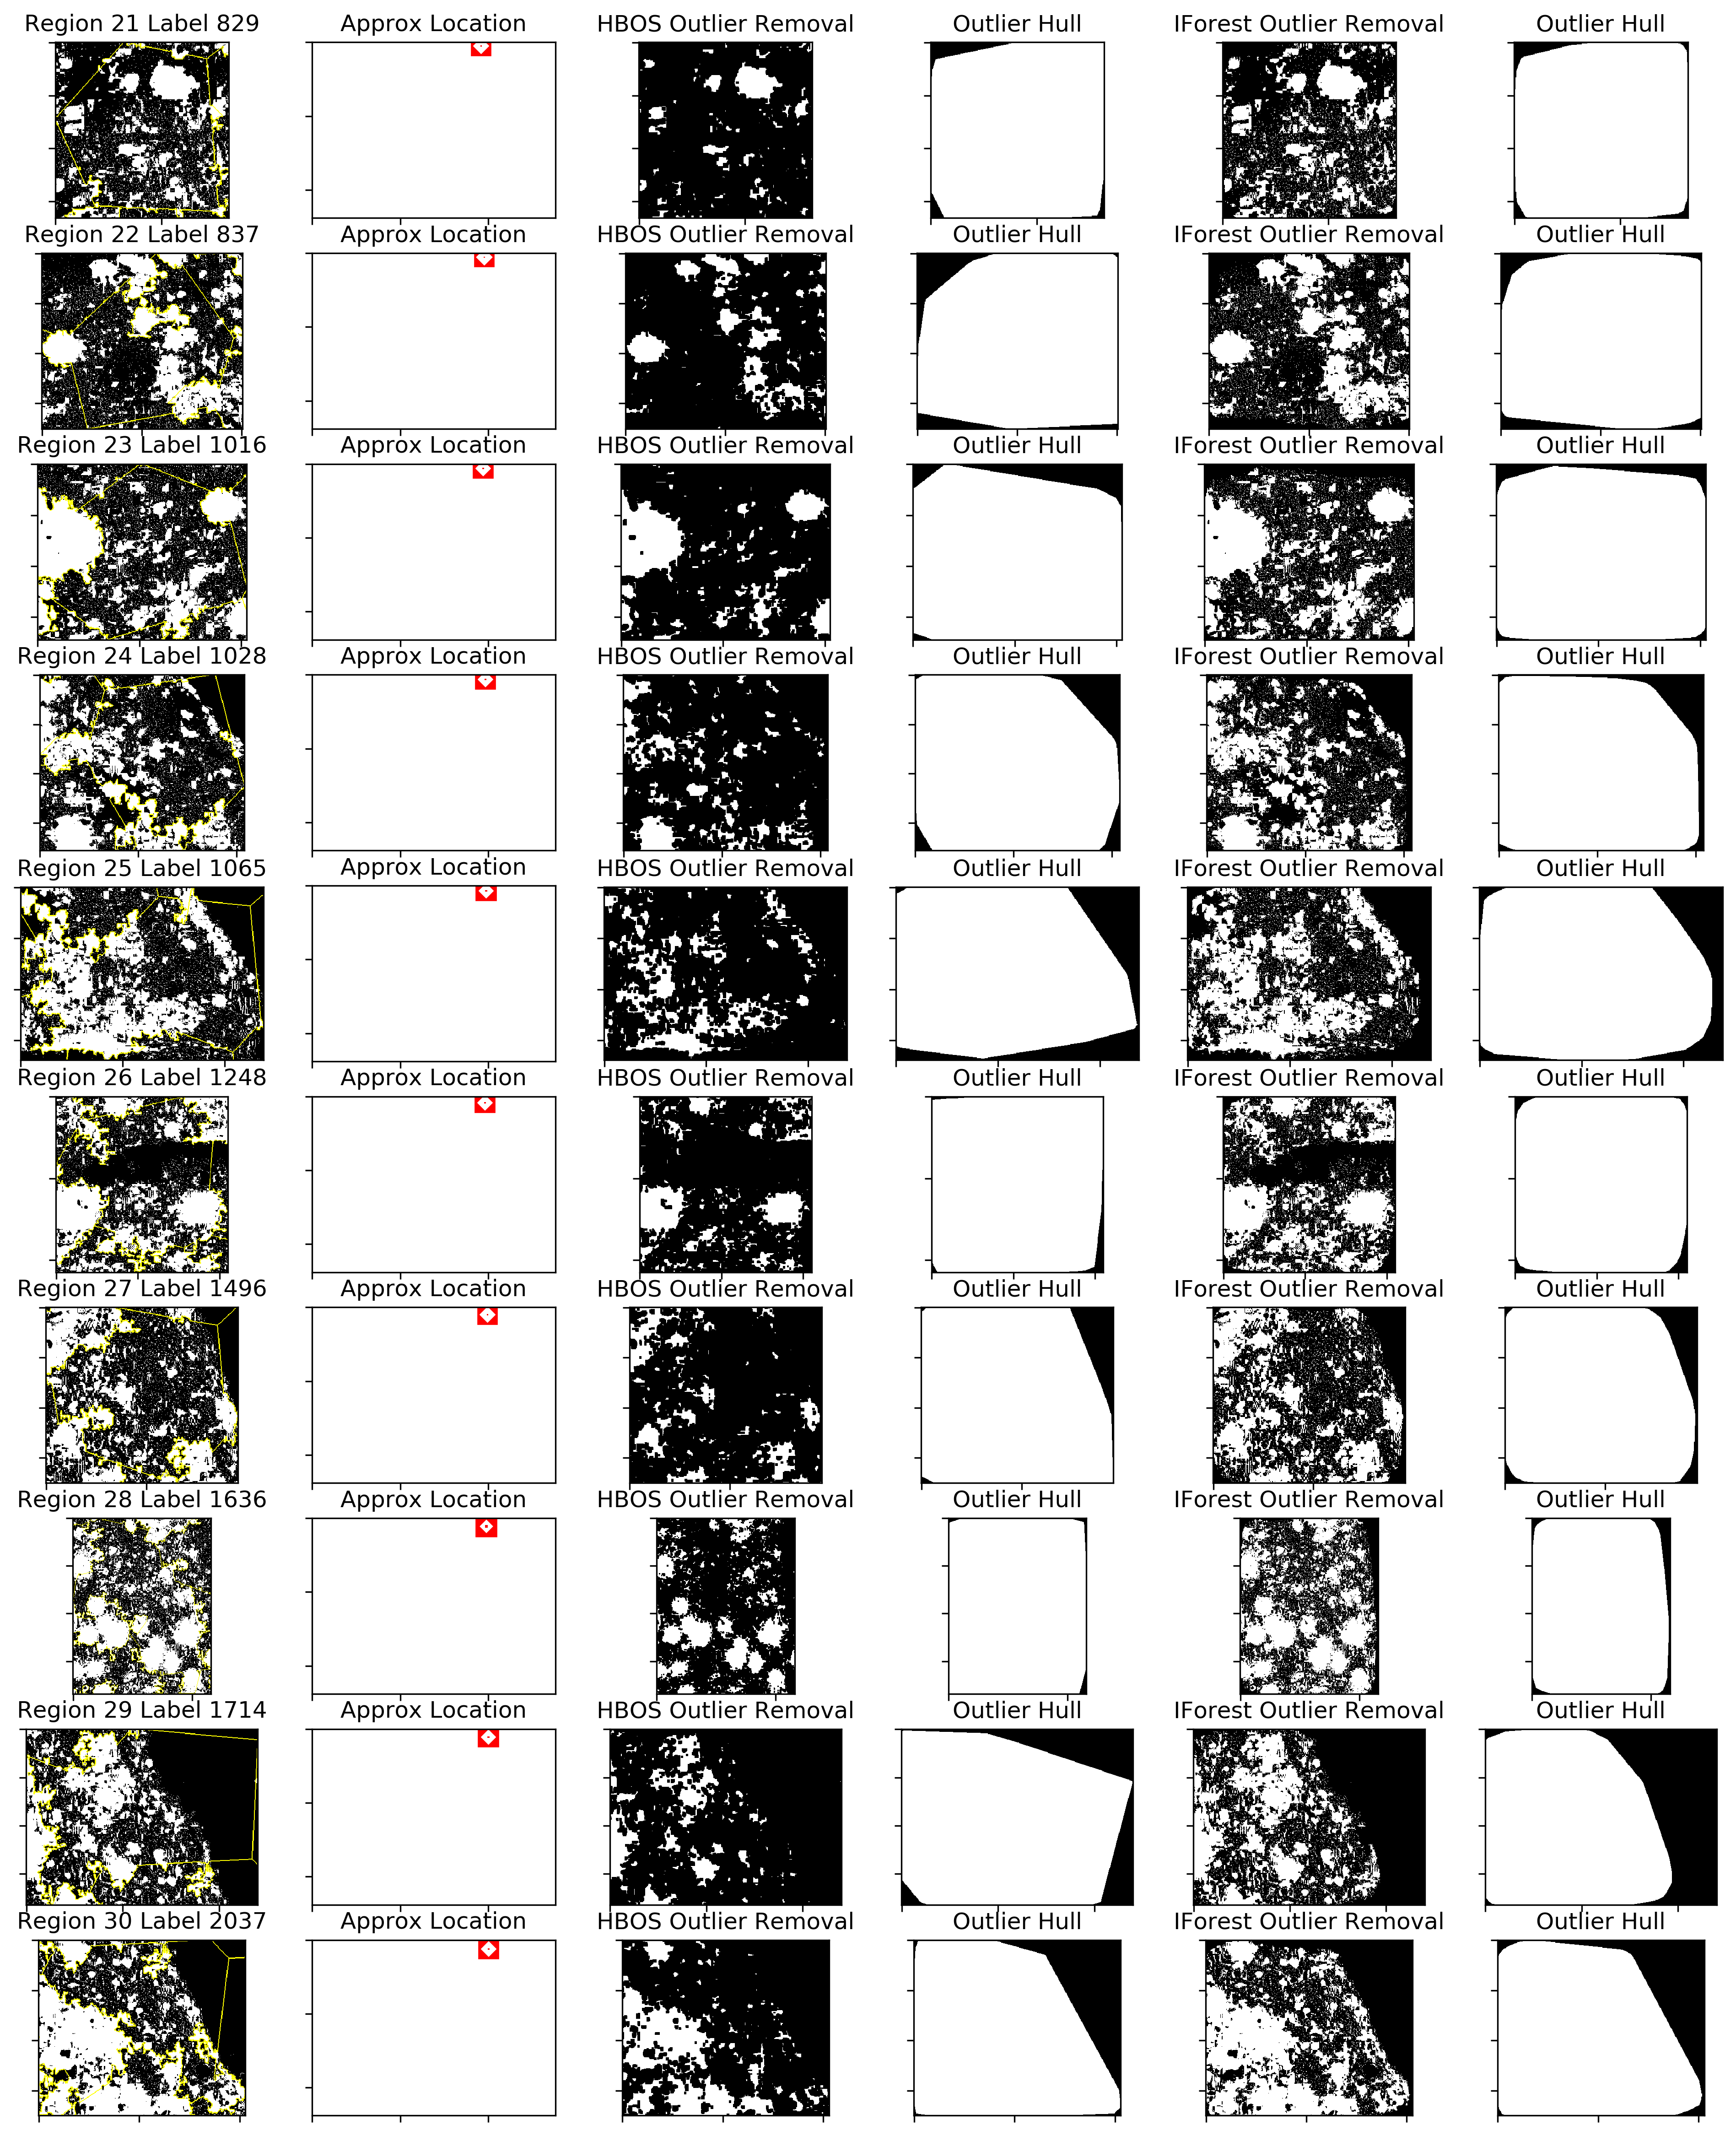

In [ ]:
# dev
import matplotlib.patches as patches
# from skimage.feature import canny
from skimage.morphology import convex_hull_image
from IPython import display

#from pyod.models.ocsvm import OCSVM
#from pyod.models.cof import COF
#from pyod.models.abod import ABOD
#from pyod.models.lscp import LSCP
#from pyod.models.loci import LOCI

from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from skimage.morphology import binary_erosion
from pyod.models.pca import PCA
from pyod.models.mcd import MCD

nrows = 10
ncols = 6
fig, axes = plt.subplots(nrows, ncols, figsize=(16,20), dpi=300)
axes = axes.reshape((-1,))
canny_times = np.zeros(nrows)
outlier_times = np.zeros(nrows)
count = 0

for region in regionprops(segments_slic, img):
    if region.label in edge_labels:
        min_r, min_c, max_r, max_c = region.bbox
        img_tile = img[min_r:max_r, min_c:max_c]
        #axes[count%nrows*ncols].imshow(img_tile, cmap='gray')
        axes[count%nrows*ncols].imshow(mark_img[min_r:max_r, min_c:max_c])
        axes[count%nrows*ncols].set_title('Region {} Label {}'.format(count+1, region.label))
        axes[count%nrows*ncols].set_xticklabels([])
        axes[count%nrows*ncols].set_yticklabels([])
        
        # Rough location within WSI
        rect = patches.Rectangle((min_c, min_r),max_c-min_c,max_r-min_r,linewidth=10,edgecolor='r',facecolor='r')
        axes[count%nrows*ncols+1].clear()
        axes[count%nrows*ncols+1].add_patch(rect)
        axes[count%nrows*ncols+1].set_xlim((0, img.shape[1]))
        axes[count%nrows*ncols+1].set_ylim((0, img.shape[0]))
        axes[count%nrows*ncols+1].invert_yaxis()
        axes[count%nrows*ncols+1].set_title('Approx Location')
        axes[count%nrows*ncols+1].set_xticklabels([])
        axes[count%nrows*ncols+1].set_yticklabels([])
        
#         # Canny edge detection
#         canny_times[count%nrows] = time()
#         canny_img = canny(img_tile, sigma=7)
#         canny_times[count%nrows] = time() - canny_times[count%nrows]
#         axes[count%nrows*ncols+2].imshow(canny_img, cmap='gray')
#         axes[count%nrows*ncols+2].set_title('Canny')
#         axes[count%nrows*ncols+2].set_xticklabels([])
#         axes[count%nrows*ncols+2].set_yticklabels([])
        
#         canny_hull_img = convex_hull_image(canny_img)
#         axes[count%nrows*ncols+3].imshow(canny_hull_img, cmap='gray')
#         axes[count%nrows*ncols+3].set_title('Canny Hull')
#         axes[count%nrows*ncols+3].set_xticklabels([])
#         axes[count%nrows*ncols+3].set_yticklabels([])
        
        # Outlier removal and convex hull
        canny_times[count%nrows] = time()
        #X = np.column_stack(np.where(img_tile==255))   # (row, col) indices
        X = np.column_stack(np.where(binary_erosion(img_tile, selem=np.ones((5,5)))))   # (row, col) indices

        model = HBOS(contamination=0.03, n_bins=100, tol=0.5) # 0.01s Very Good and doesn't eat edges        
        model.fit(X)
        outlier_img = np.zeros_like(img_tile, dtype='uint8')
        outlier_img.flat[np.ravel_multi_index(X[np.invert(model.labels_.astype('bool'))].transpose(), outlier_img.shape)] = 255
        outlier_hull_img = convex_hull_image(outlier_img)
        canny_times[count%nrows] = time() - canny_times[count%nrows]
        
        axes[count%nrows*ncols+2].imshow(outlier_img, cmap='gray')
        axes[count%nrows*ncols+2].set_title('HBOS Outlier Removal')
        axes[count%nrows*ncols+2].set_xticklabels([])
        axes[count%nrows*ncols+2].set_yticklabels([])

        axes[count%nrows*ncols+3].imshow(outlier_hull_img, cmap='gray')
        axes[count%nrows*ncols+3].set_title('Outlier Hull')
        axes[count%nrows*ncols+3].set_xticklabels([])
        axes[count%nrows*ncols+3].set_yticklabels([])
    
        # Outlier removal and convex hull
        outlier_times[count%nrows] = time()
        X = np.column_stack(np.where(img_tile==255))   # (row, col) indices
        #X = np.column_stack(np.where(binary_erosion(img_tile, selem=np.ones((3,3)))))   # (row, col) indices

        #model = OCSVM(contamination=0.03) # > 10 min
        #model = COF(contamination=0.03) # insufficient memory
        #model = ABOD(contamination=0.03, n_neighbors = 5) # nonpython TypingError
        #detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
        #         LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
        #         LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
        #         LOF(n_neighbors=50)]
        #model = LSCP(detector_list, contamination=0.03) # Combined average LOFs
        #model = LOCI(contamination=0.03) # insufficient memory
        
        #model = MCD(contamination=0.03) # 34s Good but eats edges 38s 31s
        
        #model = PCA(contamination=0.03) # 0.02s Good but eats edges 0.04s 0.02s 0.04s
        
        #model = KNN(contamination=0.5, n_neighbors = 9, method = 'mean', n_jobs=-1) # 1s
        #model = IForest(contamination=0.03, n_jobs=-1, behaviour='new') # 3s Good
        #model = CBLOF(n_clusters=9, contamination=0.03,check_estimator=False, n_jobs=-1) # 1.5-5s OK
        #model = FeatureBagging(HBOS(contamination=0.03, n_bins=10, tol=0.5), contamination=0.03, n_jobs=-1) # 9-15s Very Good
        #model = HBOS(contamination=0.03, n_bins=100, tol=0.5) # 0.01s Very Good and doesn't eat edges 0.1s 0.01s 0.02s
        
        #model = LOF(n_neighbors=35, contamination=0.03, n_jobs=-1) # 1s Very Good        
        model.fit(X)
        outlier_img = np.zeros_like(img_tile, dtype='uint8')
        outlier_img.flat[np.ravel_multi_index(X[np.invert(model.labels_.astype('bool'))].transpose(), outlier_img.shape)] = 255
        outlier_hull_img = convex_hull_image(outlier_img)
        outlier_times[count%nrows] = time() - outlier_times[count%nrows]
        
        axes[count%nrows*ncols+4].imshow(outlier_img, cmap='gray')
        axes[count%nrows*ncols+4].set_title('IForest Outlier Removal')
        axes[count%nrows*ncols+4].set_xticklabels([])
        axes[count%nrows*ncols+4].set_yticklabels([])

        axes[count%nrows*ncols+5].imshow(outlier_hull_img, cmap='gray')
        axes[count%nrows*ncols+5].set_title('Outlier Hull')
        axes[count%nrows*ncols+5].set_xticklabels([])
        axes[count%nrows*ncols+5].set_yticklabels([])
        
        if count%nrows == (nrows-1) or count == len(edge_labels)-1:
            print('Average HBOS Runtime: {} sec'.format(np.mean(canny_times)))
            print('Average IForest Runtime: {} sec'.format(np.mean(outlier_times)))
            display.display(fig)
            input("Press Enter to continue...")
            display.clear_output(wait=True)
        count += 1

print('Done')

In [15]:
# dev-final
import matplotlib.patches as patches
from skimage.morphology import convex_hull_image

from pyod.models.hbos import HBOS
from skimage.morphology import binary_erosion

currentDT = datetime.datetime.now(); print(str(currentDT)); startT = time()
mask_img3 = np.copy(mask_img2)
for region in regionprops(segments_slic, img):
    if region.label in edge_labels:
        min_r, min_c, max_r, max_c = region.bbox
        img_tile = img[min_r:max_r, min_c:max_c]
        
        # Outlier removal and convex hull
        X = np.column_stack(np.where(binary_erosion(img_tile, selem=np.ones((5,5)))))   # (row, col) indices

        model = HBOS(contamination=0.03, n_bins=100, tol=0.5) # 0.01s Very Good and doesn't eat edges        
        model.fit(X)
        outlier_img = np.zeros_like(img_tile, dtype='uint8')
        outlier_img.flat[np.ravel_multi_index(X[np.invert(model.labels_.astype('bool'))].transpose(), outlier_img.shape)] = 255
        outlier_hull_img = convex_hull_image(outlier_img)
        mask_img3[min_r:max_r, min_c:max_c] = (outlier_hull_img * 255).astype('uint8')
        
print("Outlier removal and convex hull: %s" % (time()-startT))

# Convert numpy array into PIL image and save to local
# Divide the WSI into regular slices to avoid PIL buffer overflow
slice_size = 30000
iters = np.uint8(np.ceil([height / slice_size, width / slice_size]))

save_img = Image.new('L', (width, height))
for row in range(iters[0]):
    for col in range(iters[1]):
        # Get start and end pixel location
        start_r, start_c = row * slice_size, col * slice_size
        end_r, end_c = min(height, start_r + slice_size), min(width, start_c + slice_size)

        # Paste the slice mask to image mask
        save_slice = Image.fromarray(mask_img3[start_r:end_r, start_c:end_c], 'L')
        save_img.paste(save_slice, (start_c, start_r))
# Save masked image
save_img.save('NA3777-02_AB_Eosin_SLIC_40000_finalmask.png')

print('Saved')
print("Total: %s" % (time()-startT))

2019-09-12 06:59:27.425913
SLIC: 20.022282600402832
Saved
Total: 68.26713752746582


2001
(4721, 11616, 5082, 11979)
255
252.2951626565326
0
slice(4721, 5082, None)
slice(11616, 11979, None)
[[ 4721 11616]
 [ 4721 11617]
 [ 4721 11618]
 ...
 [ 5081 11976]
 [ 5081 11977]
 [ 5081 11978]]


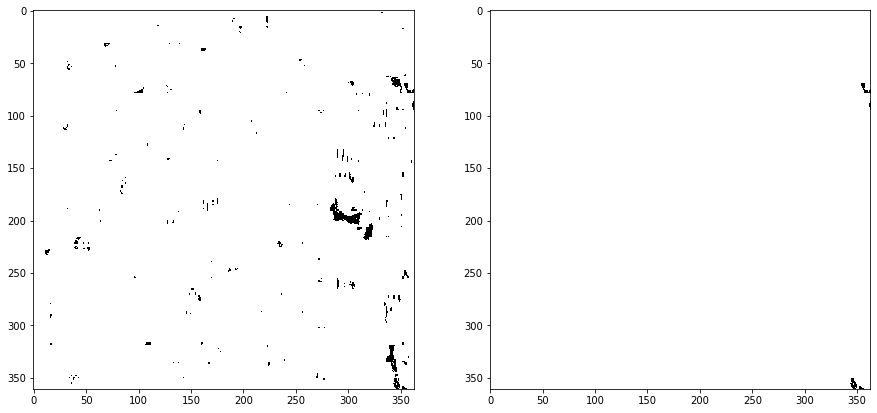

In [62]:
from skimage.measure import regionprops
from scipy.ndimage.morphology import binary_fill_holes
count = 0
for region in regionprops(segments_slic, img):
    if count < 2000:
        count+=1
        continue
    print(region.label)
    print(region.bbox)
    print(region.max_intensity)
    print(region.mean_intensity)
    print(region.min_intensity)
    print(region.slice[0])
    print(region.slice[1])
    print(region.coords)
    fig = plt.figure(figsize=(15,30))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(img[region.bbox[0]:region.bbox[2], region.bbox[1]:region.bbox[3]], cmap='gray')
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(binary_fill_holes(img[region.bbox[0]:region.bbox[2], region.bbox[1]:region.bbox[3]]), cmap='gray', vmin=0, vmax=1)
    break